In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)

# Climate Model

#### Inputs: Emissions vector, radiative forcing $(\dfrac{W}{m^2})$
#### Outputs: [GHG]s, non-CO2 radiative forcing, temperature anomaly relative to pre-industrial levels

##### Parameters


ECS- Climate Sensitivity Parameter, change in temperature if [GHG] doubles. Reasonable range: 1.5-4.5°C

TCR- Transient Climate Response, also a measure of climate sensitivity. 

Carbon Sinks Breakdown- Partioning of carbon sinks as well as CO2 lifetime


$(C, F, T)=$ GHG Concentration (ppm), Radiative Forcing ($\dfrac{W}{m^2}$), Temperature Anomaly (°C). Model output of FaIR

In [2]:
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.SSPs import ssp245, ssp370, ssp585
import fair
print(fair.__version__)

# "engine" of the fair model is the fair_scm function 
from fair.forward import fair_scm

1.6.4


In [11]:
print(ssp245.Emissions.emissions.shape)
print(ssp245.Concentrations.concentrations.shape)
print(ssp245.Forcing.total.shape)

(736, 40)
(736, 32)
(736,)


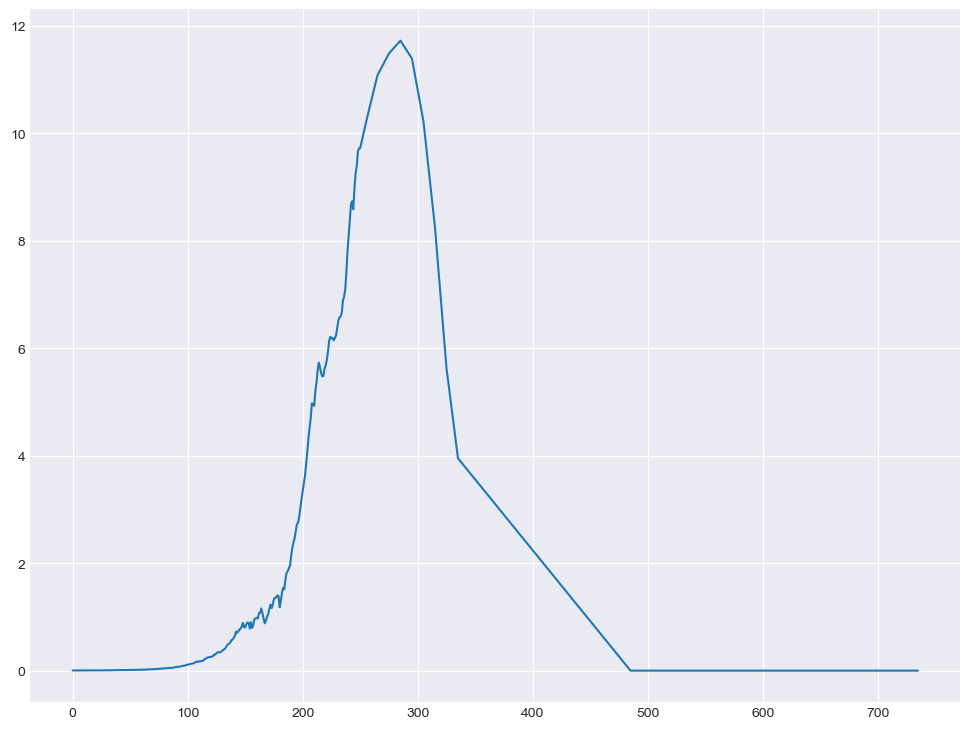

In [18]:
plt.plot(ssp245.Emissions.emissions[:,1])

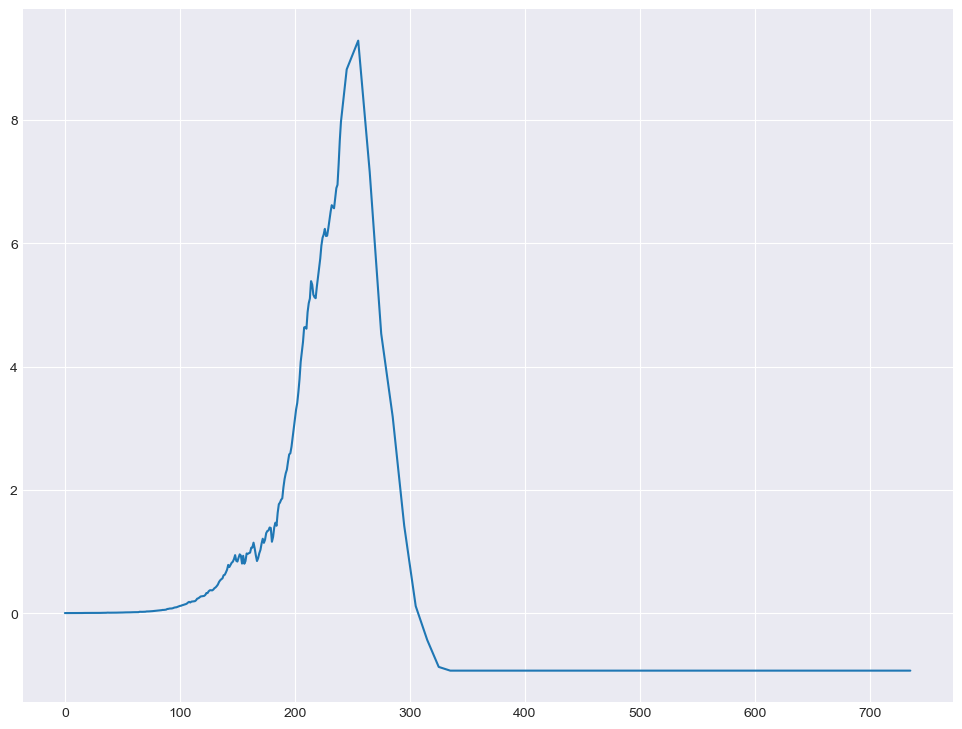

In [17]:
plt.plot(rcp26.Emissions.emissions[:,1])

## Setting up Parameters

In [5]:
def rand(a,b):
    # generates random value between a and b
    return(a + (b-a)*random.random())

In [6]:
ECS = rand(1.5, 4.5) # equilibrium climate sensitivity
ECS = 3.2 # reasonable, errs on more realistic side. Default FAIR calye is 2.6
ECS

3.2

In [7]:
TCR = rand(1, 2.5)
TCR = 2 # more realistic, default value in FAIR is 1.75
TCR

2

#### Default Parameter Values from Table 1 for FaIR

For more info, read the following literature:

https://acp.copernicus.org/articles/17/7213/2017/acp-17-7213-2017.pdf

In [8]:
# partioning coefficients
a0 = 0.2173
a1 = 0.2240
a2 = 0.2824
a3 = 0.2763

a = [a0, a1, a2, a3]

assert sum(a)==1.0, "Partioning Coefficients must add to one"

# CO2 lifetime coefficients
To = 1000000
T1 = 394.4
T2 = 36.54
T3 = 4.303

tau = [To, T1, T2, T3]

q1 = 0.33
q2 = 0.41

d1 = 239.0
d2 = 4.1

r0 = 32.40
rC = 0.019
rT = 4.165

iIRF100- 100 year integrated impulse response function. $F(C_{acc}, GMST)$

$C_{acc}= \sum (E-(C-C_0)$ accumulated perturbation carbon stock in land and ocean. Emitted carbon no longer in atmosphere

$r_0, r_c, r_t$ - preindustrial sensitivity of carbon sinks, change with cumulative carbon intake, change to temperature change

GMST: Global Mean Surface temperature anomaly from pre-industrial

Adequate linear approximation

In [9]:
r0 = 32.40
rC = 0.019
rT = 4.165
def iRF100(C, T):
    return(r0 + rC*C + rT * T)

In [10]:
iRF100(100, 1.2)

39.297999999999995

# Running the Model

In [11]:
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.SSPs import ssp370, ssp245, ssp585
import fair
print(fair.__version__)

# "engine" of the fair model is the fair_scm function 
from fair.forward import fair_scm

1.6.4


In [12]:
start_year = 2022
end_year = 2100
n = end_year - start_year
n

78

# Using partial function for code

In [13]:
from fair.forward import fair_scm
from functools import partial

def set_climate_parameters(values):
    # values is a dictionary that accepts whichever FaIR climate parameters we care to set
    # uses dictionary unpacking as well as partial function calling

    return(partial(fair_scm, **values))



In [14]:
n=250
emissions = np.zeros(n) # CO2 emissions in every year, nx1
emissions[n//2:] = 10.0
args = {
    "other_rf" : 0.5 * np.sin(2 * np.pi *  np.arange(250) / 14), 
    "useMultigas" : False
}

C_prime, F_p, T_p = set_climate_parameters(args)(emissions)
partial_func = set_climate_parameters(args)

# Using Scenarios

## Saving ssp dataset

In [93]:
import requests
import os
from bs4 import BeautifulSoup
from fair.SSPs import ssp126, ssp245, ssp370, ssp585
scenarios = {"ssp126": ssp126, "ssp245": ssp245, "ssp370": ssp370, "ssp585": ssp585}
scenarios

{'ssp126': <fair.SSPs.FaIRHelper at 0x13b0a6ac0>,
 'ssp245': <fair.SSPs.FaIRHelper at 0x13b3a9fa0>,
 'ssp370': <fair.SSPs.FaIRHelper at 0x13b3a9e80>,
 'ssp585': <fair.SSPs.FaIRHelper at 0x13b4cd850>}

In [58]:
url = "https://docs.fairmodel.net/en/v1.6.4_a/examples.html"
r = requests.get(url)
soup = BeautifulSoup(r.content, "html.parser")
type(soup)

bs4.BeautifulSoup

In [99]:
table1, table2, table3 = soup.find_all("table")
emission_labels = {}
for tr in table1.find_all('tr')[1:]:
    index, species, unit = tr.find_all('td')
    emission_labels[int(index.text)] = species.text + " (" + unit.text + ")"
emission_labels[0] = "Year"
    
concentration_labels = {}
for tr in table2.find_all('tr')[1:]:
    index, species, unit = tr.find_all('td')
    concentration_labels[int(index.text)] = species.text + " (" + unit.text + ")"

forcing_labels = {}
for tr in table3.find_all('tr')[1:]:
    index, species = tr.find_all('td')
    forcing_labels[int(index.text)] = species.text

In [100]:
print(emission_labels)
print()
print(concentration_labels)
print()
print(forcing_labels)

{0: 'Year', 1: 'CO2-fossil (GtC/yr)', 2: 'CO2-landuse (GtC/yr)', 3: 'CH4 (Mt/yr)', 4: 'N2O (MtN2/yr)', 5: 'SOx (MtS/yr)', 6: 'CO (Mt/yr)', 7: 'NMVOC (Mt/yr)', 8: 'NOx (MtN/yr)', 9: 'BC (Mt/yr)', 10: 'OC (Mt/yr)', 11: 'NH3 (Mt/yr)', 12: 'CF4 (kt/yr)', 13: 'C2F6 (kt/yr)', 14: 'C6F14 (kt/yr)', 15: 'HFC23 (kt/yr)', 16: 'HFC32 (kt/yr)', 17: 'HFC43-10 (kt/yr)', 18: 'HFC125 (kt/yr)', 19: 'HFC134a (kt/yr)', 20: 'HFC143a (kt/yr)', 21: 'HFC227ea (kt/yr)', 22: 'HFC245fa (kt/yr)', 23: 'SF6 (kt/yr)', 24: 'CFC11 (kt/yr)', 25: 'CFC12 (kt/yr)', 26: 'CFC113 (kt/yr)', 27: 'CFC114 (kt/yr)', 28: 'CFC115 (kt/yr)', 29: 'CCl4 (kt/yr)', 30: 'Methyl chloroform (kt/yr)', 31: 'HCFC22 (kt/yr)', 32: 'HCFC141b (kt/yr)', 33: 'HCFC142b (kt/yr)', 34: 'Halon 1211 (kt/yr)', 35: 'Halon 1202 (kt/yr)', 36: 'Halon 1301 (kt/yr)', 37: 'Halon 2401 (kt/yr)', 38: 'CH3Br (kt/yr)', 39: 'CH3Cl (kt/yr)'}

{0: 'CO2 (ppm)', 1: 'CH4 (ppb)', 2: 'N2O (ppb)', 3: 'CF4 (ppt)', 4: 'C2F6 (ppt)', 5: 'C6F14 (ppt)', 6: 'HFC23 (ppt)', 7: 'HFC32 (

In [101]:
emission_labels

{0: 'Year',
 1: 'CO2-fossil (GtC/yr)',
 2: 'CO2-landuse (GtC/yr)',
 3: 'CH4 (Mt/yr)',
 4: 'N2O (MtN2/yr)',
 5: 'SOx (MtS/yr)',
 6: 'CO (Mt/yr)',
 7: 'NMVOC (Mt/yr)',
 8: 'NOx (MtN/yr)',
 9: 'BC (Mt/yr)',
 10: 'OC (Mt/yr)',
 11: 'NH3 (Mt/yr)',
 12: 'CF4 (kt/yr)',
 13: 'C2F6 (kt/yr)',
 14: 'C6F14 (kt/yr)',
 15: 'HFC23 (kt/yr)',
 16: 'HFC32 (kt/yr)',
 17: 'HFC43-10 (kt/yr)',
 18: 'HFC125 (kt/yr)',
 19: 'HFC134a (kt/yr)',
 20: 'HFC143a (kt/yr)',
 21: 'HFC227ea (kt/yr)',
 22: 'HFC245fa (kt/yr)',
 23: 'SF6 (kt/yr)',
 24: 'CFC11 (kt/yr)',
 25: 'CFC12 (kt/yr)',
 26: 'CFC113 (kt/yr)',
 27: 'CFC114 (kt/yr)',
 28: 'CFC115 (kt/yr)',
 29: 'CCl4 (kt/yr)',
 30: 'Methyl chloroform (kt/yr)',
 31: 'HCFC22 (kt/yr)',
 32: 'HCFC141b (kt/yr)',
 33: 'HCFC142b (kt/yr)',
 34: 'Halon 1211 (kt/yr)',
 35: 'Halon 1202 (kt/yr)',
 36: 'Halon 1301 (kt/yr)',
 37: 'Halon 2401 (kt/yr)',
 38: 'CH3Br (kt/yr)',
 39: 'CH3Cl (kt/yr)'}

In [109]:
os.makedirs("fair_ssp_scenarios")
for name, scenario in scenarios.items():
    data = {}
    for key, var in emission_labels.items():
        data[var] = scenario.Emissions.emissions[:, key]
    df = pd.DataFrame(data)
    path = os.path.join('fair_ssp_scenarios', name + "_emissions.csv")
    df.to_csv(path)
    
    data = {'Year' : scenario.Concentrations.concentrations[:,0]} # labels do not include year
    for key, var in concentration_labels.items():
        data[var] = scenario.Concentrations.concentrations[:, key+1]
    df = pd.DataFrame(data)
    path = os.path.join('fair_ssp_scenarios', name + "_concentrations.csv")
    df.to_csv(path)

In [111]:
pd.read_csv('fair_ssp_scenarios/ssp245_concentrations.csv').drop(['Unnamed: 0'],axis=1)

,Year,CO2 (ppm),CH4 (ppb),N2O (ppb),CF4 (ppt),C2F6 (ppt),C6F14 (ppt),HFC23 (ppt),HFC32 (ppt),HFC43-10 (ppt),...,Methyl chloroform (ppt),HCFC22 (ppt),HCFC141b (ppt),HCFC142b (ppt),Halon 1211 (ppt),Halon 1202 (ppt),Halon 1301 (ppt),Halon 2401 (ppt),CH3Br (ppt),CH3Cl (ppt)
0,1765.0,277.913000,738.986038,274.372047,34.049999,0.00000,0.000000,0.00000,0.000003,0.0,...,0.0,0.0,0.0,0.0,0.004447,0.0,0.000000,0.0,5.299998,457.000002
1,1766.0,277.958000,739.831085,274.392052,34.049999,0.00000,0.000000,0.00000,0.000005,0.0,...,0.0,0.0,0.0,0.0,0.004447,0.0,0.000000,0.0,5.299998,457.000002
2,1767.0,278.016998,740.728984,274.426051,34.049999,0.00000,0.000000,0.00000,0.000008,0.0,...,0.0,0.0,0.0,0.0,0.004447,0.0,0.000000,0.0,5.299998,457.000002
3,1768.0,278.077995,741.222056,274.447047,34.049999,0.00000,0.000000,0.00000,0.000010,0.0,...,0.0,0.0,0.0,0.0,0.004447,0.0,0.000000,0.0,5.299998,457.000002
4,1769.0,278.135005,741.747050,274.468051,34.049999,0.00000,0.000000,0.00000,0.000013,0.0,...,0.0,0.0,0.0,0.0,0.004447,0.0,0.000000,0.0,5.299998,457.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2496.0,579.768997,997.339930,359.840983,140.825001,9.59912,0.685107,3.15741,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.003763,0.0,4.880721,411.666018
732,2497.0,579.599996,997.329925,359.825979,140.822000,9.59816,0.684886,3.14129,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.003707,0.0,4.880821,411.677010
733,2498.0,579.432007,997.319931,359.811981,140.818998,9.59720,0.684665,3.12525,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.003651,0.0,4.880931,411.688014
734,2499.0,579.264002,997.310928,359.797984,140.815999,9.59624,0.684444,3.10929,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.003597,0.0,4.881031,411.699013


In [94]:
concentration_labels

{0: 'CO2 (ppm)',
 1: 'CH4 (ppb)',
 2: 'N2O (ppb)',
 3: 'CF4 (ppt)',
 4: 'C2F6 (ppt)',
 5: 'C6F14 (ppt)',
 6: 'HFC23 (ppt)',
 7: 'HFC32 (ppt)',
 8: 'HFC43-10 (ppt)',
 9: 'HFC125 (ppt)',
 10: 'HFC134a (ppt)',
 11: 'HFC143a (ppt)',
 12: 'HFC227ea (ppt)',
 13: 'HFC245fa (ppt)',
 14: 'SF6 (ppt)',
 15: 'CFC11 (ppt)',
 16: 'CFC12 (ppt)',
 17: 'CFC113 (ppt)',
 18: 'CFC114 (ppt)',
 19: 'CFC115 (ppt)',
 20: 'CCl4 (ppt)',
 21: 'Methyl chloroform (ppt)',
 22: 'HCFC22 (ppt)',
 23: 'HCFC141b (ppt)',
 24: 'HCFC142b (ppt)',
 25: 'Halon 1211 (ppt)',
 26: 'Halon 1202 (ppt)',
 27: 'Halon 1301 (ppt)',
 28: 'Halon 2401 (ppt)',
 29: 'CH3Br (ppt)',
 30: 'CH3Cl (ppt)'}

In [106]:
ssp245.Concentrations.concentrations[:, 0]

array([1765., 1766., 1767., 1768., 1769., 1770., 1771., 1772., 1773.,
       1774., 1775., 1776., 1777., 1778., 1779., 1780., 1781., 1782.,
       1783., 1784., 1785., 1786., 1787., 1788., 1789., 1790., 1791.,
       1792., 1793., 1794., 1795., 1796., 1797., 1798., 1799., 1800.,
       1801., 1802., 1803., 1804., 1805., 1806., 1807., 1808., 1809.,
       1810., 1811., 1812., 1813., 1814., 1815., 1816., 1817., 1818.,
       1819., 1820., 1821., 1822., 1823., 1824., 1825., 1826., 1827.,
       1828., 1829., 1830., 1831., 1832., 1833., 1834., 1835., 1836.,
       1837., 1838., 1839., 1840., 1841., 1842., 1843., 1844., 1845.,
       1846., 1847., 1848., 1849., 1850., 1851., 1852., 1853., 1854.,
       1855., 1856., 1857., 1858., 1859., 1860., 1861., 1862., 1863.,
       1864., 1865., 1866., 1867., 1868., 1869., 1870., 1871., 1872.,
       1873., 1874., 1875., 1876., 1877., 1878., 1879., 1880., 1881.,
       1882., 1883., 1884., 1885., 1886., 1887., 1888., 1889., 1890.,
       1891., 1892.,

## Using ssp datasets for runs

2040


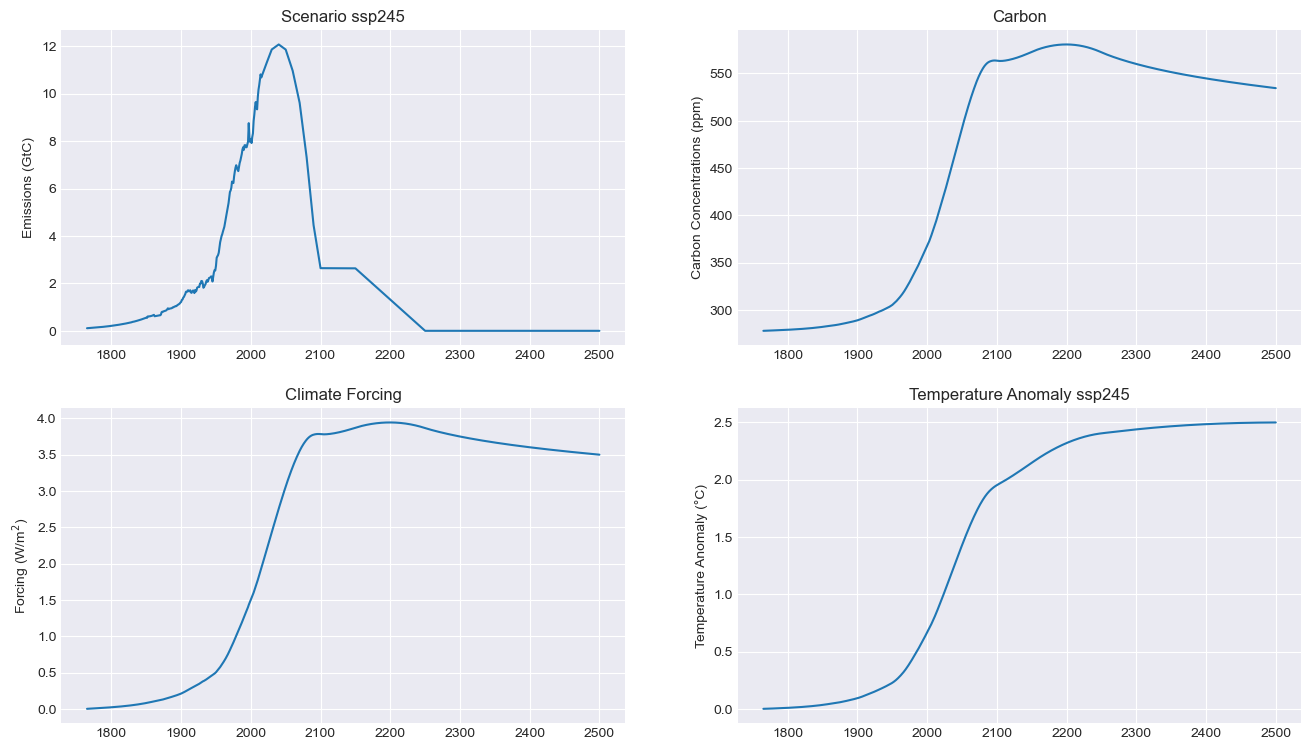

In [15]:
import fair
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.SSPs import ssp370, ssp245, ssp585
scenario = "ssp245"

climate_params = {
    "a" : np.array([0.2173, 0.2240, 0.2824, 0.2763]),
    "tau" : np.array([1000000, 394.4, 36.54, 4.303]),
    "r0" : 32.40,
    "rc" : 0.019,
    "rt" : 4.165,
    "useMultigas":False
}

forward = partial(fair.forward.fair_scm, **climate_params)

base_emissions_full = eval(scenario).Emissions
if climate_params['useMultigas']:
    base_emissions=base_emissions_full.emissions
else:
    base_emissions = np.array([x[1]+x[2] for x in base_emissions_full.emissions])

emissions_peak = eval(scenario).Emissions.year[np.where(base_emissions==max(base_emissions))[0][0]] # 2040
print(emissions_peak)

C1, F1, T1 = forward(emissions=base_emissions)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(eval(scenario).Emissions.year, base_emissions)
ax1.set_ylabel("Emissions (GtC)")
ax1.set_title("Scenario " + scenario)

ax2.plot(eval(scenario).Emissions.year, C1)
ax2.set_ylabel("Carbon Concentrations (ppm)")
ax2.set_title("Carbon")

ax3.plot(eval(scenario).Emissions.year, F1)
ax3.set_ylabel("Forcing (W/m$^{2}$)")
ax3.set_title("Climate Forcing")

ax4.plot(eval(scenario).Emissions.year, T1)
ax4.set_ylabel("Temperature Anomaly (°C)")
ax4.set_title("Temperature Anomaly " + scenario)

plt.show()

## Single Gas (carbon only) Mode

In [16]:
n = 125
plt.rcParams['figure.figsize'] = (4, 3)

In [17]:
emissions = np.zeros(n) # CO2 emissions in every year, nx1
emissions[n//2:] = 10.0
#plt.plot(emissions, color="black")
#plt.show()

In [18]:
forcing = 0.5 * np.sin(2 * np.pi *  np.arange(250) / 14)
#plt.plot(forcing)
#plt.show()

#### Running the Model

In [19]:
n=250
emissions = np.zeros(n) # CO2 emissions in every year, nx1
emissions[n//2:] = 10.0
forcing = 0.5 * np.sin(2 * np.pi *  np.arange(250) / 14)

C, F, T = fair.forward.fair_scm(emissions=emissions, other_rf=forcing, useMultigas=False)

In [20]:
print(C.shape)
print(F.shape)
print(T.shape)

(250,)
(250,)
(250,)


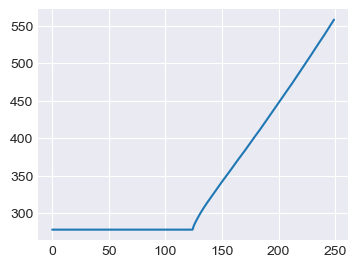

In [21]:
plt.plot(C)

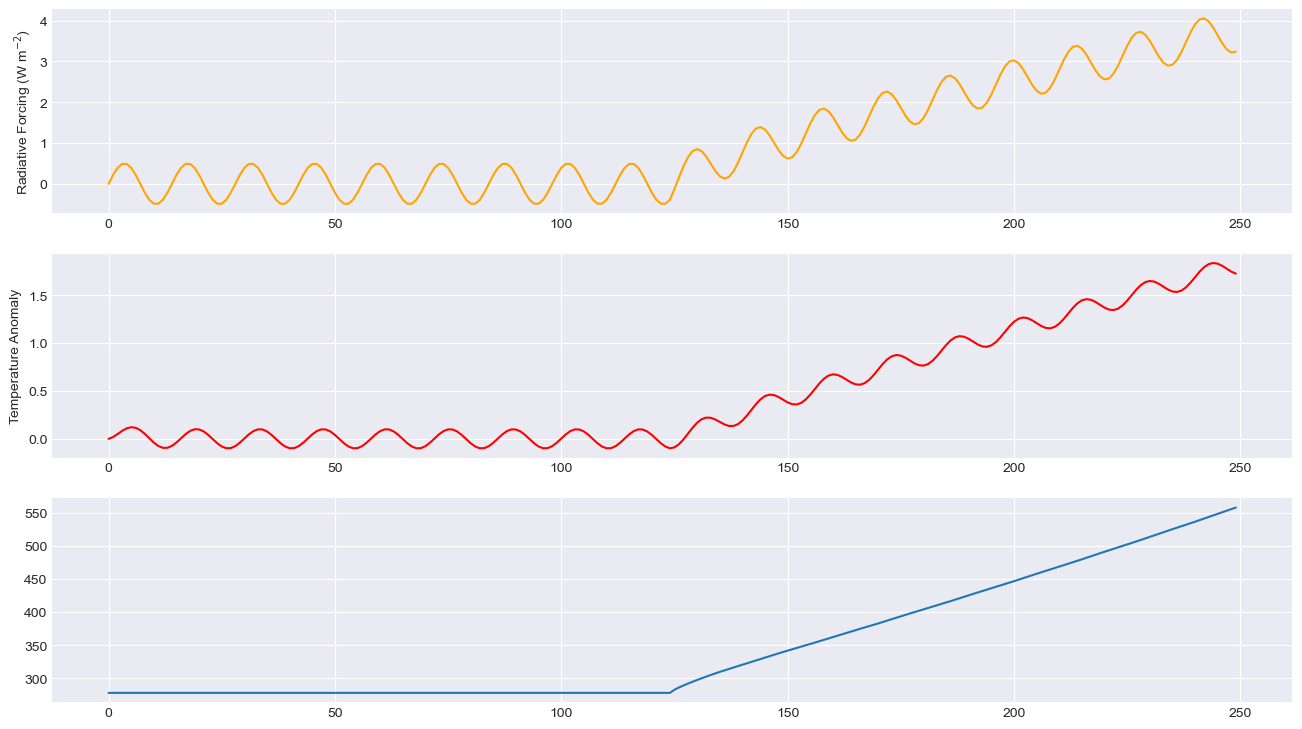

In [22]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(311)
ax.plot(F, color='orange')
ax.set_ylabel("Radiative Forcing (W m$^{-2}$)")
ax2 = fig.add_subplot(312)
ax2.plot(T, color='red')
ax2.set_ylabel("Temperature Anomaly")
ax3 = fig.add_subplot(313)
ax3.plot(C)
plt.show()

# Sensitivity to Parameters

In [23]:
n = 250
emissions = 10 * np.ones(n)
emissions[n//2:] = 0.0
forcing = 0.5 * np.sin(2/14*np.pi*np.arange(n))

Run    ro    rc    rt
  0  37.484 0.0197 3.821
  1  34.309 0.0210 3.755
  2  38.238 0.0173 4.991
  3  42.615 0.0202 3.877
  4  33.829 0.0204 4.714
  5  33.829 0.0131 4.628
  6  42.896 0.0198 3.668
  7  38.837 0.0143 3.736
  8  32.653 0.0237 4.202
  9  37.713 0.0168 4.430


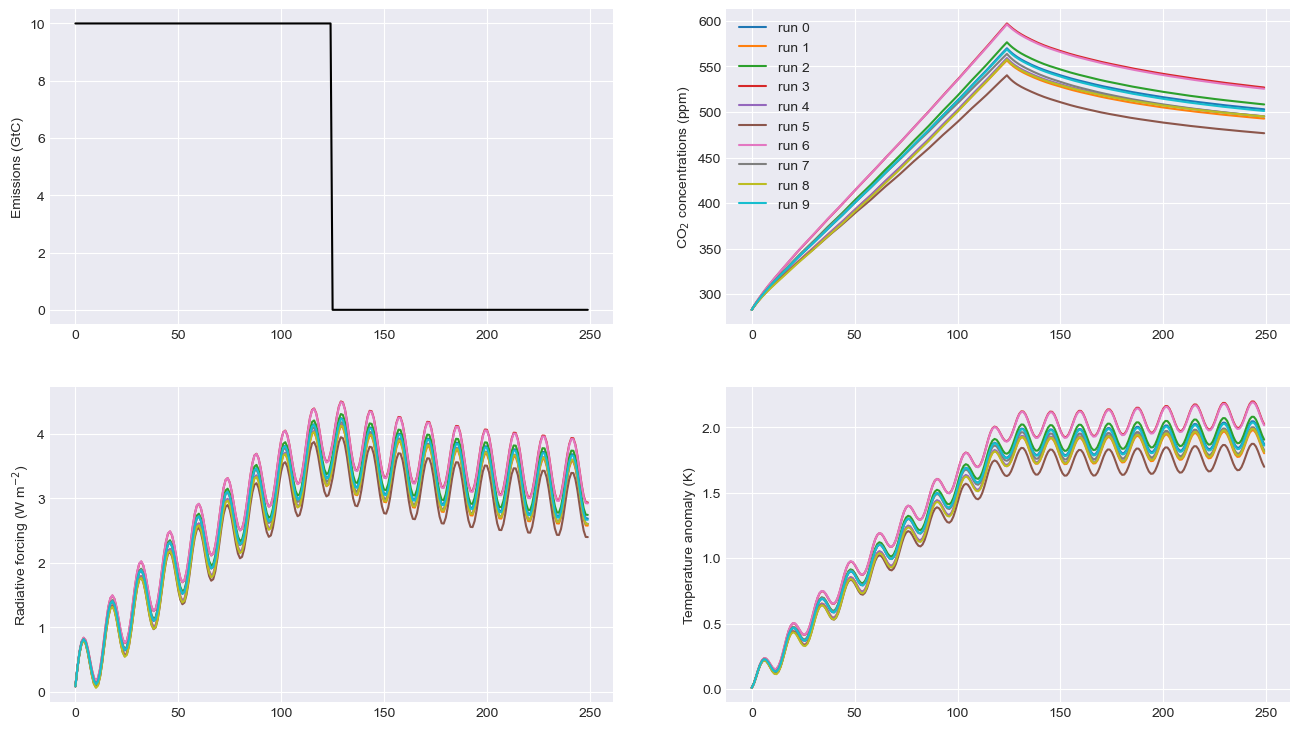

In [24]:
runs = 10

C = np.empty((n, runs))
F = np.empty((n, runs))
T = np.empty((n, runs))

from scipy.stats import norm
r0 = norm.rvs(size=runs, loc=35, scale=5.0, random_state=42)
rc = norm.rvs(size=runs, loc=0.019, scale=0.003, random_state=77)
rt = norm.rvs(size=runs, loc=4.165, scale=0.5, random_state=1729)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(221)
ax1.plot(emissions, color='black')
ax1.set_ylabel("Emissions (GtC)")
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

print("Run    ro    rc    rt")
for run in range(runs):
    print ("  %d  %5.3f %5.4f %5.3f" % (run, r0[run], rc[run], rt[run]))
    
    C[:, run], F[:, run], T[:, run] = fair_scm(emissions=emissions, 
                                             other_rf=forcing, 
                                             useMultigas=False,
                                            r0=r0[run], rc=rc[run], rt=rt[run])
    ax2.plot(C[:,run], label='run %d' % run)
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(F[:,run])
    ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
    ax4.plot(T[:,run])
    ax4.set_ylabel('Temperature anomaly (K)');

ax2.legend();
plt.show()

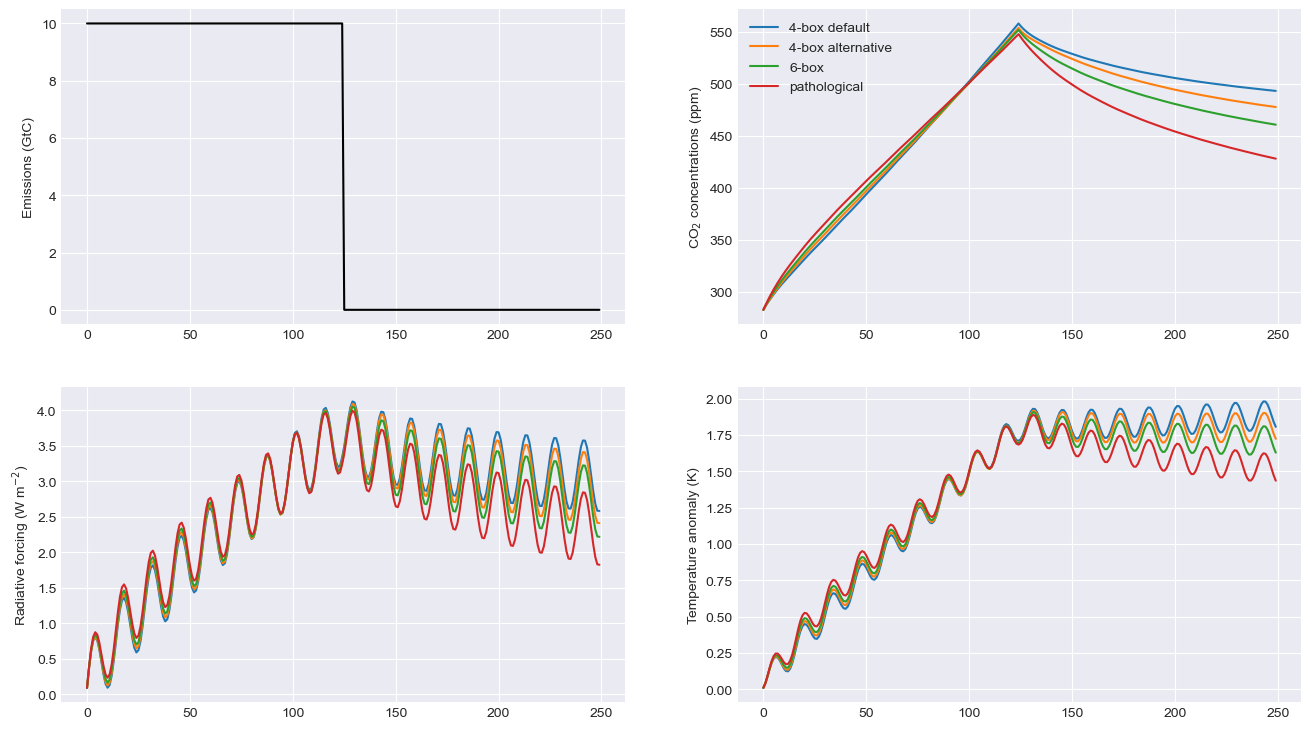

In [25]:
# create output arrays
n = 250
runs = 4
C = np.empty((n, runs))
F = np.empty((n, runs))
T = np.empty((n, runs))

# Play with the carbon boxes

#defaults used in paper
a0 = 0.2173
a1 = 0.2240
a2 = 0.2824
a3 = 0.2763
To = 1000000
T1 = 394.4
T2 = 36.54
T3 = 4.303
a = np.array([0.2173, 0.2240, 0.2824, 0.2763])
tau = np.array([1000000, 394.4, 36.54, 4.303])


tau2 = np.array([1e6, 400.0, 100.0, 5.0])
a2   = np.ones(4) * 0.25

# Nobody said we had to stick to a four-box model...
tau3 = np.array([1e6, 1000.0, 150.0, 70.0, 15.0, 3.0])
a3   = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

# A pathological case where tau0 is much smaller than 1e6
# in this example CO2 behaves more like other GHGs
tau4 = np.array([10., 4., 1., 0.3])
a4   = a

# run the model for default values (same as not specifying at all)
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=forcing,
    useMultigas=False,
    tau=tau, a=a)

# ... and for our alternatives
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=forcing,
    useMultigas=False,
    tau=tau2,
    a=a2)
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=forcing,
    useMultigas=False,
    tau=tau3,
    a=a3)
C[:,3],F[:,3],T[:,3] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=forcing,
    useMultigas=False,
    tau=tau4,
    a=a4)

# plot the output
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(221)
ax1.plot(emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
handles = ax2.plot(range(0, emissions.size), C)
labels = ['4-box default','4-box alternative','6-box','pathological']
ax2.legend(handles, labels)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

## Multi-gas Mode

In [26]:
np.set_printoptions(suppress=True)

In [34]:
n = end_year - start_year
emissions = np.ones((n, 40))

# [year, CO2_emissions, CO2_land, ...]

emissions[:, 0] = np.arange(start_year, end_year)
emissions[:3, :8]

array([[2022.,    1.,    1.,    1.,    1.,    1.,    1.,    1.],
       [2023.,    1.,    1.,    1.,    1.,    1.,    1.,    1.],
       [2024.,    1.,    1.,    1.,    1.,    1.,    1.,    1.]])

In [ ]:
def generate_forcing(n, param):
    cunculations = param + 1 # let us say this is some output from our GHG
    vector = np.random.randn(n, 13)
    for i in range(n): # aerosols are at position 9, index 8
        vector[i, 8] += cunculations
    return vector

forcing = generate_forcing(num_years,4)
forcing[:7,7:11]

# From Documentation

https://fair.readthedocs.io/en/latest/examples.html

In [104]:
import fair
from fair.forward import fair_scm
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.SSPs import ssp370, ssp245, ssp585

fair.__version__

'1.6.4'

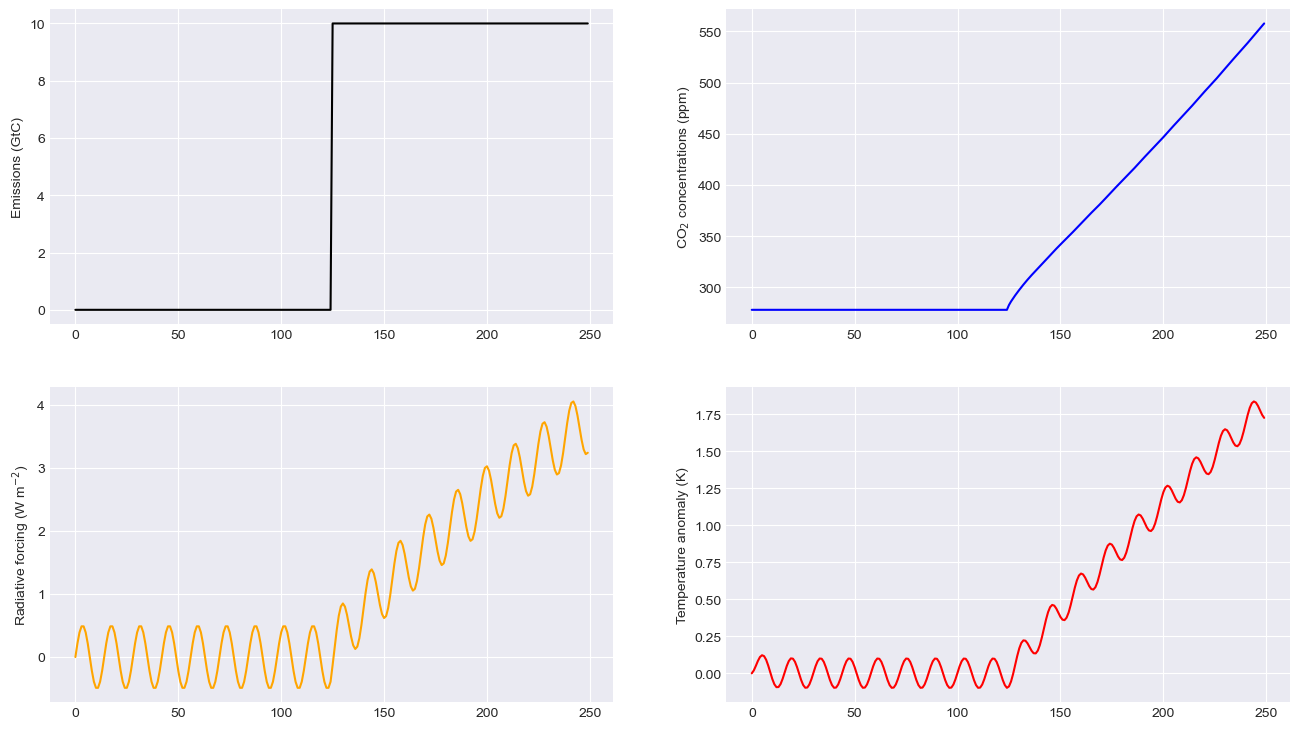

In [6]:
# set up emissions and forcing arrays
emissions = np.zeros(250)   # Unit: GtC
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# run the model
C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C, color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F, color='orange')
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T, color='red')
ax4.set_ylabel('Temperature anomaly (K)');

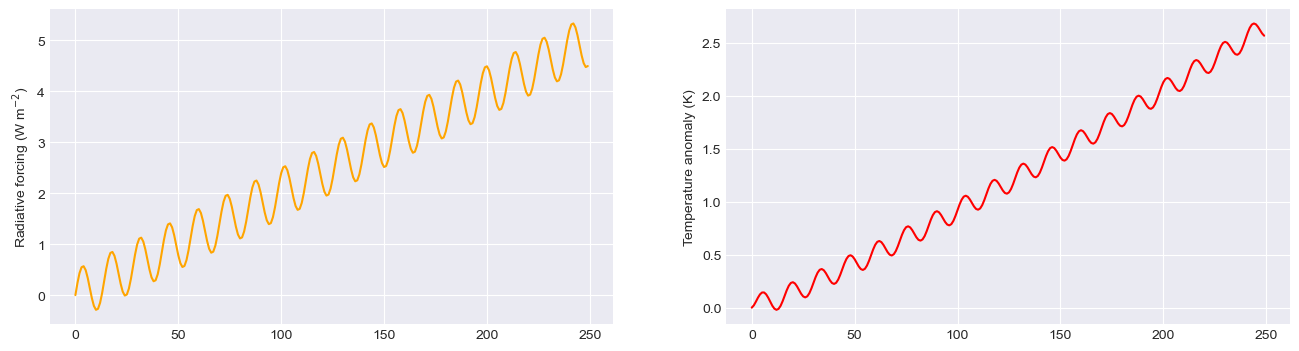

In [7]:
# Define a forcing time series
for x in range(0, emissions.size):
    other_rf[x] = 0.02*x + 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# run the model with emissions off
_,F,T = fair.forward.fair_scm(
    emissions=False,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, other_rf.size), F, color='orange')
ax1.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax1 = fig.add_subplot(222)
ax1.plot(range(0, other_rf.size), T, color='red')
ax1.set_ylabel('Temperature anomaly (K)');

run      r0     rc    rt
  0  37.484 0.0197 3.821
  1  34.309 0.0210 3.755
  2  38.238 0.0173 4.991
  3  42.615 0.0202 3.877
  4  33.829 0.0204 4.714
  5  33.829 0.0131 4.628
  6  42.896 0.0198 3.668
  7  38.837 0.0143 3.736
  8  32.653 0.0237 4.202
  9  37.713 0.0168 4.430


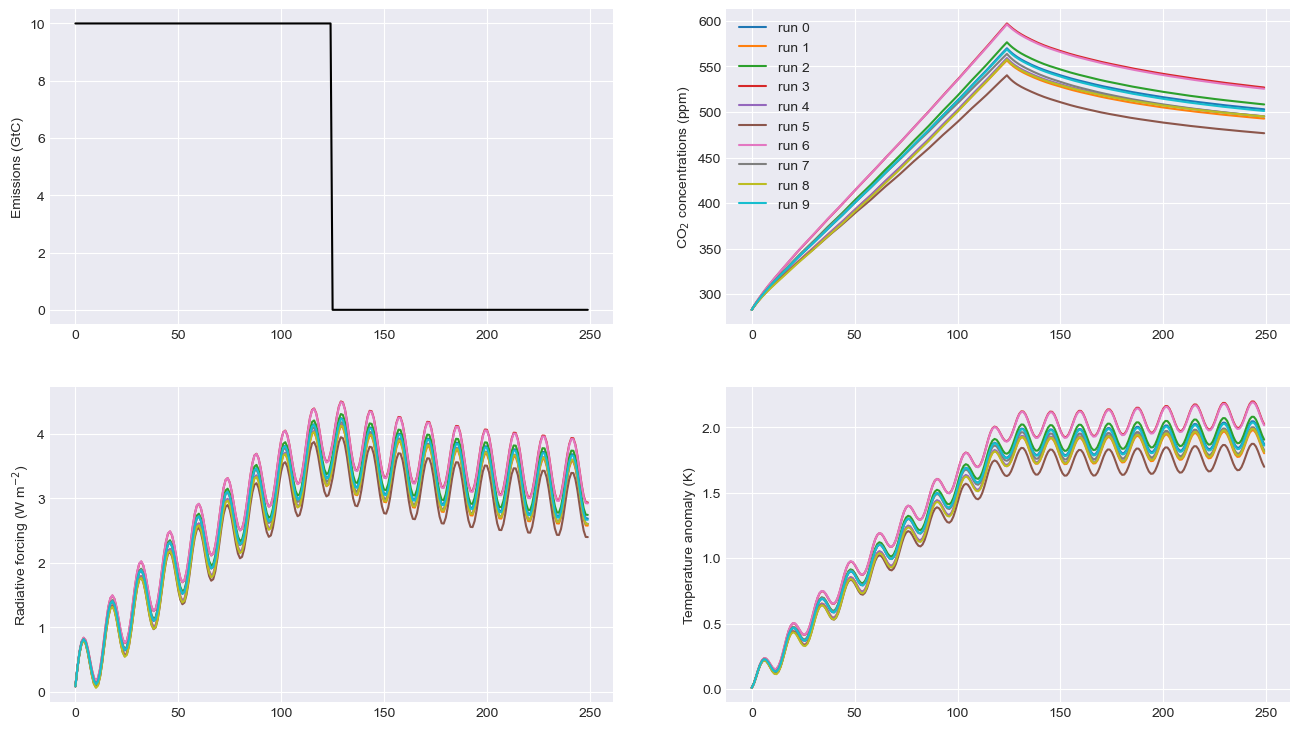

In [8]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays
nrun = 10
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Generate some random values of carbon cycle parameters
# use a seed for reproducible results
from scipy.stats import norm
r0 = norm.rvs(size=nrun, loc=35, scale=5.0, random_state=42)
rc = norm.rvs(size=nrun, loc=0.019, scale=0.003, random_state=77)
rt = norm.rvs(size=nrun, loc=4.165, scale=0.5, random_state=1729)

# initialise plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# run the model and plot outputs
print ("run      r0     rc    rt")
for i in range(nrun):
    print ("  %d  %5.3f %5.4f %5.3f" % (i, r0[i], rc[i], rt[i]))
    C[:,i],F[:,i],T[:,i] = fair.forward.fair_scm(
        emissions=emissions,
        other_rf=other_rf,
        useMultigas=False,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    ax2.plot(range(0, emissions.size), C[:,i], label='run %d' % i)
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(range(0, emissions.size), F[:,i])
    ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
    ax4.plot(range(0, emissions.size), T[:,i])
    ax4.set_ylabel('Temperature anomaly (K)');
ax2.legend();

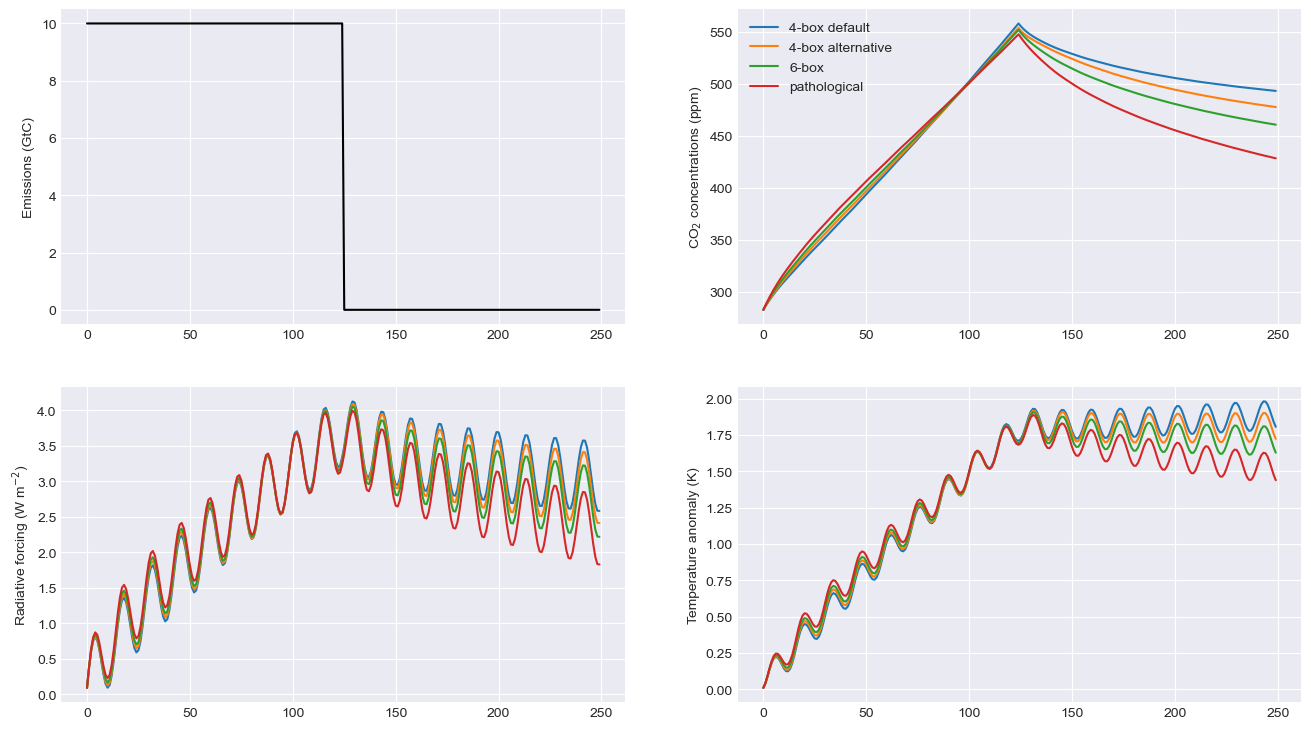

In [9]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays
nrun=4
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Play with the carbon boxes
tau2 = np.array([1e6, 400.0, 100.0, 5.0])
a2   = np.ones(4) * 0.25

# Nobody said we had to stick to a four-box model...
tau3 = np.array([1e6, 1000.0, 150.0, 70.0, 15.0, 3.0])
a3   = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

# A pathological case where tau0 is much smaller than 1e6
# in this example CO2 behaves more like other GHGs
tau4 = np.array([10., 4., 1., 0.3])
a4   = np.ones(4) * 0.25

# run the model for default values
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False)

# ... and for our alternatives
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau2,
    a=a2)
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau3,
    a=a3)
C[:,3],F[:,3],T[:,3] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau4,
    a=a4)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
handles = ax2.plot(range(0, emissions.size), C)
labels = ['4-box default','4-box alternative','6-box','pathological']
ax2.legend(handles, labels)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

# Scenarios

In [5]:
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.SSPs import ssp370, ssp245, ssp585
import fair
from fair.forward import fair_scm

In [7]:
emissions = ssp245.Emissions.emissions
emissions.shape

(736, 40)

In [9]:
emissions[0]

(40,)